In [1]:
import numpy as np
import matplotlib.pyplot as plt
import resfuncRead as rfr
import pandas as pd
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit

In [2]:
#read the files (from anthony)
#ptres = rfr.getRFunc('data/jardin_ptres.txt')
#qres = rfr.getRFunc('data/jardin_qsummaxres.txt')

In [3]:
k = 0.157 # from lindhard
q = 1.602*10**-19 #electron charge 
V = 4.0 # voltage Bias
eps = .0033 #keV

#for detector 1.

p_alpha = 0.155393
p_beta = 9.60343*10**(-11)
p_gamma = 0.000506287

q_alpha = 0.166004
q_beta = 0.00233716
q_gamma = 9.52576*10**(-5)

In [4]:
#x = np.arange(0,200,0.002)
#Er = 93*np.exp(-x/29) #For NR from Kennedy Thesis 

N = 10000
Er = np.random.exponential(40,np.uint32(N*0.3)) #tip from anthony 

#need to store all of this inorder to calculate fano factor.
ER = []
Yield = []
PtNr = []
QR = []
sigQ = []
sigP = []
sigQ1 = []
sigP1 = []

U1 = []
U2 = []
N_eh = []

QNR=[]
PT1 = []


In [5]:
#For Nuclear Recoils 
F =100

'''
Neh = Y*Enr/eps
#(ylindv(Enr*1000.0)*Enr)/(eps/1000)
sigf_p = q*V*np.sqrt(Neh*F)
sigf_q = eps*np.sqrt(Neh*F)
'''

for i in np.arange(0,N):
    
    Enr = np.random.choice(Er)

    esp = 11.5*Enr*(23)**-(7/3)
    g = 3*esp**(0.15)+0.7*esp**(0.6)+esp
    Y = k*g/(1+k*g)
    

    
    Neh = Y*Enr/eps #number of electron-hole pairs. 
    Ptnr = (Y*Enr*V)/(eps*1000) + Enr #central value of Pt
    Qnr = Y*Enr
    
    
    N_eh.append(Neh)
    #(ylindv(Enr*1000.0)*Enr)/(eps/1000)
    #sigf_p = q*V*np.sqrt(Neh*F)
    #sigf_q = eps*np.sqrt(Neh*F)
    
    
    #Without Fano Factor 
    sig_p1 = np.sqrt(p_alpha + p_beta*Ptnr + p_gamma*(Ptnr**2) )  
    sig_q1 = np.sqrt(q_alpha + q_beta*Qnr + q_gamma*(Qnr**2) )
    
   #With Fano Factor. 
    sig_p = np.sqrt(p_alpha + p_beta*Ptnr + p_gamma*(Ptnr**2) + (V/1000)**2*Neh*F)  #Phonon uncertainty (energy dependent)
    sig_q = np.sqrt(q_alpha + q_beta*Qnr + q_gamma*(Qnr**2) + eps**2*Neh*F) #Charge uncertainty 
    

    
    sigQ.append(sig_q)
    sigP.append(sig_p)
    sigQ1.append(sig_q1)
    sigP1.append(sig_p1)
    
    Fnr = np.random.normal(0.0,sig_p) #random sample assuming phonon variance 
    Fq = np.random.normal(0.0,sig_q) #random sampel assuming charge variance 
    

    #Ptnr = (Y*Enr*V)/eps + Enr #total phonon energy 
    Ptnr1 = Ptnr + Fnr #not central value! just.. smeared 
    PT1.append(Ptnr1)

    Qnr1 = Qnr + Fq 

    QNR.append(Qnr1)
    
    U_1 = (Ptnr*eps**2)/((V*Qnr1/1000)-Ptnr1*eps)**2 #derivative with respect to Qnr1
    U1.append(U_1)
    U_2 = -Qnr1/(Ptnr1 -(Qnr1*V/(eps*1000)))**2      #derivative with respect to Ptnf
    U2.append(U_2)
    
    Ernr = Ptnr1 - (V/(eps*1000))*Qnr1
    ER.append(Ernr)

    yield1 = Qnr1 / Ernr
    Yield.append(yield1)

    

In [6]:
Yield_er = []
ERer = []



In [7]:
#For Electron Recoils. 

#x = np.arange(0,2000,0.1)
#E1er = 82*np.exp(-x/304) #For ER from Kennedy Thesis
E1er = np.random.uniform(0,200,N) #from anthony, Er's are close enough to randomly distributed. 



for i in np.arange(N):
    
    Eer = np.random.choice(E1er) #randomly sample from Energy dist 
    
    
    sig_pee = np.sqrt(p_alpha + p_beta*Eer + p_gamma*(Eer**2)) #Phonon uncertainty 
    sig_qee = np.sqrt(q_alpha + q_beta*Eer + q_gamma*(Eer**2)) #Charge uncertainty 

    Fer = np.random.normal(0.0,sig_pee) #Random energy assuming phonon variance 
    Fqe = np.random.normal(0.0,sig_qee) #Random assuming charge variane


    Pter = (1+(V/eps/1000))*Eer 
    Pter = Pter + Fer
    Qer = Eer
    Qer = Qer + Fqe

    Erer = Pter - (V/eps/1000)*Qer
    ERer.append(Erer)
    
    Yield2 = Qer/Erer
    Yield_er.append(Yield2)

In [8]:
# Make band Fits (Thank you Anthony)

# files contain fits from previous data. I believe that they are fits from real data. As seen, the model has a significantly narrower spread the fits 
# from the data 

bpar_er = rfr.getBandFunc('data/erband_R133') #reads in band data/fit for er data
bpar_nr = rfr.getBandFunc('data/nrband_R133') #reads in band data/fit for nr data 

yer_mu = rfr.makeBFunc(bpar_er[1]['mu']) # sets average fit from 1st (2nd) col in data table. 
yer_muv = np.vectorize(yer_mu) #puts mean data for er in 1D array 
yer_sig = rfr.makeBFunc(bpar_er[1]['sig'],True) #sets uncertainty 
yer_sigv = np.vectorize(yer_sig) #puts uncertainty into 1D array

#following does the same but for nuclear recoils. 
ynr_mu = rfr.makeBFunc(bpar_nr[1]['mu'])
ynr_muv = np.vectorize(ynr_mu)
ynr_sig = rfr.makeBFunc(bpar_nr[1]['sig'],True)
ynr_sigv = np.vectorize(ynr_sig)

# try new fit

xn = np.arange(0.1,100,0.1)
m, c = np.polyfit(ER, Yield, 1)
yn = np.polyval([m, c], xn)

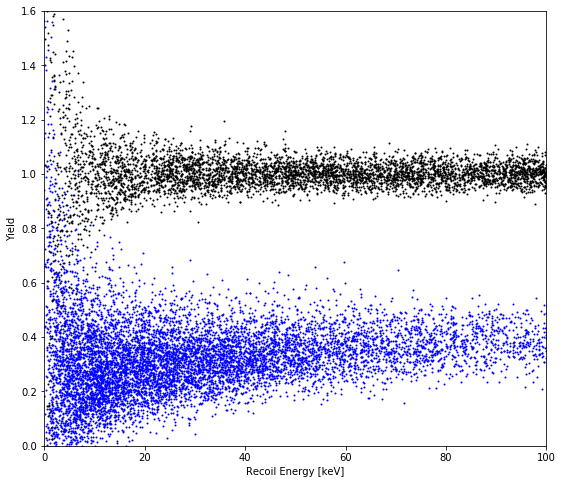

In [9]:
#plot 


fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


X = np.arange(0.1,100,0.1)

ax1.plot(ER,Yield,'o',color='b',linewidth=2,markersize=1)
ax1.plot(ERer,Yield_er,'o',color='k',linewidth=2,markersize=1)
'''
ax1.plot(X,ynr_muv(X),color = 'orange',label='NR mu') #using old data 
#ax1.plot(xn,yn,'r--') #new fit to data (mean)

ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\sigma$')
ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

ax1.plot(X,yer_muv(X),color='purple',linestyle='--',label='ER mu')
ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='purple',linestyle='-',label='ER 3$\sigma$')
ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='purple',linestyle='-',label=None)
'''
ax1.set_xlabel('Recoil Energy [keV]')
ax1.set_ylabel('Yield')
ax1.set_ylim(0,1.6)
ax1.set_xlim(0,100)


plt.show()


In [10]:

data = np.vstack((ER,Yield,sigQ1,sigP1,U1,U2,N_eh)).T
print(data.shape)

x = data[data[:,1]>=0, :]

data1 = x[x[:,1]<=1.6,:]
data2 = data1[data1[:,0]>=0,:]


#data = np.vstack((Er,Y)).T
#print(data)
#np.savetxt("test_data.txt",data)

data1 = data2[np.argsort(data2[:, 0])]



(10000, 7)


In [11]:
#a,b,c,d,e,f,g = np.array_split(data1,7)
data = np.array_split(data1,20)



In [12]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [13]:
#Finds the width in a yield dist for a particular energy bin to be used later in yield variance calculation (fano)
def find_sigma(data):
    mu,sigma = norm.fit(data[:,1])
    
   # gaus(data[:,1],2,0.03,0.05)
    
    n,bins = np.histogram(data[:,1],60)
    
    a = max(data[:,1])
    b = np.average(data[:,1])
    c = sigma
    
    popt,pcov = curve_fit(gaus,bins[:-1],n,p0=[a,b,c])
    
    #y = mlab.normpdf(bins, mu, sigma)
 
    plt.figure()
    plt.hist(data[:,1],bins =60)
    plt.plot(bins,gaus(bins,*popt), 'r--', linewidth = 2)
    plt.xlabel("Yield")
    plt.show()
    
    return  pcov, popt

In [14]:
#finds average fano in particular energy bin
def gaus1(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_fano(data):
    
    mu,sigma = norm.fit(data)
    
    #gaus1(data,2,0.03,0.05)
    
    n,bins = np.histogram(data,60)
    
        
    a = max(data)
    b = mu
    c = sigma
    
    
    popt1,pcov1 = curve_fit(gaus1,bins[:-1],n,p0=[a,b,c])
    
    #y = mlab.normpdf(bins, mu, sigma)
 
    plt.figure()
    plt.hist(data,bins =60)
    plt.plot(bins,gaus(bins,*popt1), 'r--', linewidth = 2)
    plt.xlabel("Extracted Fano")
    plt.show()
    
    return  popt1, pcov1, mu

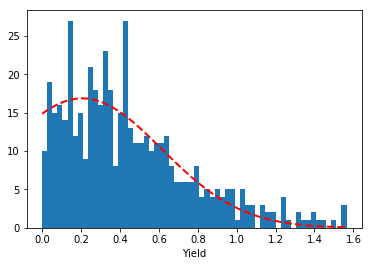

[[ 0.67373765 -0.00310475 -0.00961298]
 [-0.00310475  0.00293932 -0.00206071]
 [-0.00961298 -0.00206071  0.00225445]] [16.87987026  0.20626637  0.41002512]


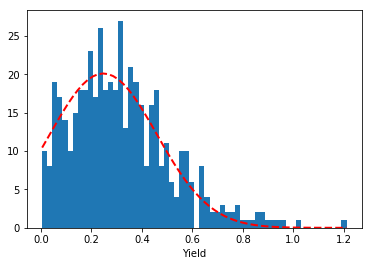

[[ 7.31873242e-01  1.55850156e-03 -6.91735391e-03]
 [ 1.55850156e-03  1.50055436e-04 -6.53875819e-05]
 [-6.91735391e-03 -6.53875819e-05  1.86847283e-04]] [20.11838534  0.24726433  0.211843  ]


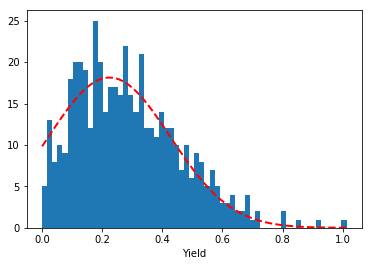

[[ 4.89770627e-01  1.18512585e-03 -4.97194016e-03]
 [ 1.18512585e-03  1.18285654e-04 -5.53398537e-05]
 [-4.97194016e-03 -5.53398537e-05  1.46289090e-04]] [18.14690637  0.22443768  0.2020601 ]


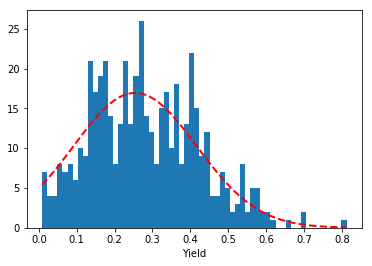

[[ 9.93101219e-01  8.95963870e-04 -7.50284339e-03]
 [ 8.95963870e-04  1.31148148e-04 -2.59463987e-05]
 [-7.50284339e-03 -2.59463987e-05  1.57651715e-04]] [16.9400487   0.25436316  0.16230262]


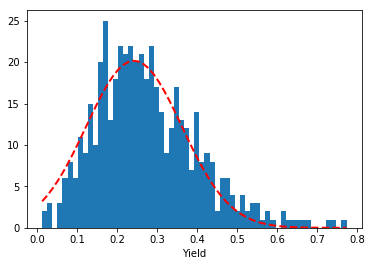

[[ 6.38474215e-01  1.11037307e-04 -2.69643967e-03]
 [ 1.11037307e-04  3.02045894e-05 -1.70606003e-06]
 [-2.69643967e-03 -1.70606003e-06  3.28075505e-05]] [20.16401617  0.24249514  0.11980539]


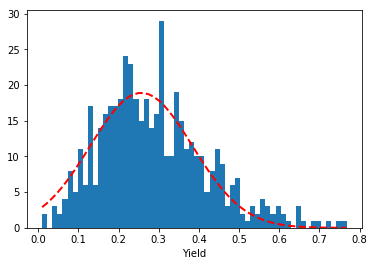

[[ 8.69290595e-01  1.62700554e-04 -4.15164404e-03]
 [ 1.62700554e-04  5.28442344e-05 -2.82317410e-06]
 [-4.15164404e-03 -2.82317410e-06  5.72060736e-05]] [18.89535547  0.25674763  0.12731589]


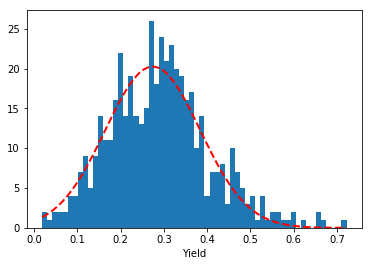

[[ 6.37007735e-01  2.31367726e-05 -2.33963895e-03]
 [ 2.31367726e-05  2.48502080e-05 -2.98540547e-07]
 [-2.33963895e-03 -2.98540547e-07  2.54491091e-05]] [20.24541887  0.2742455   0.10961474]


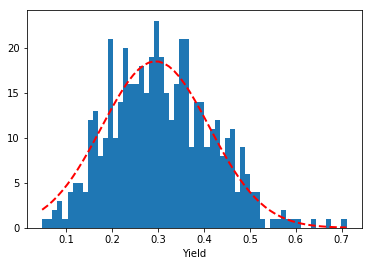

[[ 5.63119172e-01  5.67546483e-05 -2.47259847e-03]
 [ 5.67546483e-05  3.01784033e-05 -8.92859311e-07]
 [-2.47259847e-03 -8.92859311e-07  3.17368109e-05]] [18.49054192  0.29418648  0.11727128]


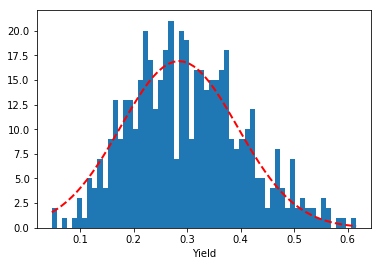

[[ 5.98729630e-01  4.65930021e-05 -2.66013911e-03]
 [ 4.65930021e-05  3.32173896e-05 -7.38466587e-07]
 [-2.66013911e-03 -7.38466587e-07  3.46684444e-05]] [16.90283179  0.28475699  0.10913739]


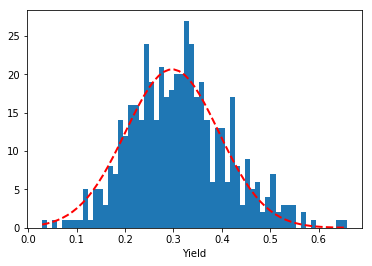

[[ 7.63007603e-01  3.01788583e-06 -2.37315507e-03]
 [ 3.01788583e-06  2.20147596e-05 -3.17720567e-08]
 [-2.37315507e-03 -3.17720567e-08  2.20961087e-05]] [20.66156609  0.2972854   0.09614287]


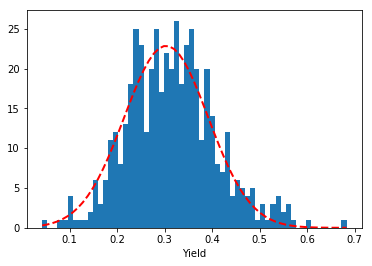

[[ 8.23275933e-01  1.16267565e-06 -2.12820164e-03]
 [ 1.16267565e-06  1.64612083e-05 -1.00511634e-08]
 [-2.12820164e-03 -1.00511634e-08  1.64884105e-05]] [22.84798854  0.3030307   0.08849579]


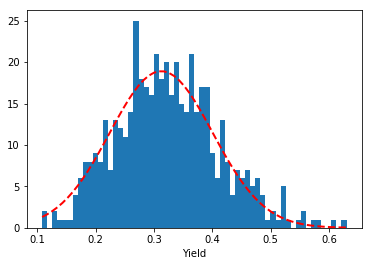

[[4.74867771e-01 1.63943770e-05 1.50670420e-03]
 [1.63943770e-05 1.37777631e-05 1.83169496e-07]
 [1.50670420e-03 1.83169496e-07 1.41416614e-05]] [18.91030067  0.3125562  -0.08829758]


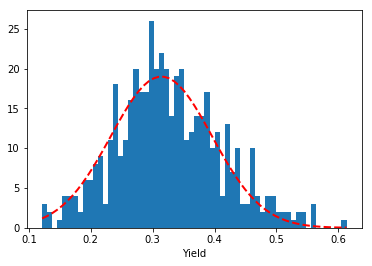

[[6.79249774e-01 1.78152047e-05 1.97961905e-03]
 [1.78152047e-05 1.67312521e-05 1.82069438e-07]
 [1.97961905e-03 1.82069438e-07 1.71027346e-05]] [18.98619882  0.31419741 -0.08167686]


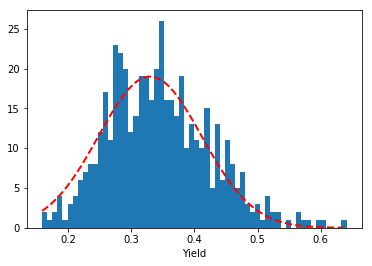

[[ 6.89396402e-01  4.90240322e-05 -2.05237916e-03]
 [ 4.90240322e-05  1.69432927e-05 -5.23362326e-07]
 [-2.05237916e-03 -5.23362326e-07  1.78473397e-05]] [19.00125067  0.32977509  0.08160216]


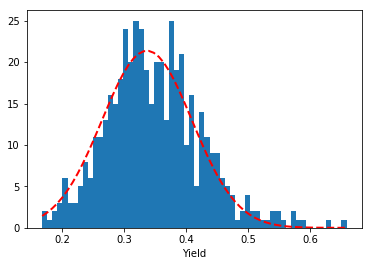

[[ 6.18979534e-01  1.43479597e-05 -1.42556165e-03]
 [ 1.43479597e-05  9.48909139e-06 -1.16128575e-07]
 [-1.42556165e-03 -1.16128575e-07  9.72145255e-06]] [21.37229291  0.33705094  0.07253762]


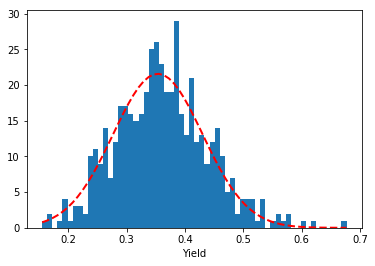

[[ 6.42966433e-01  5.25838331e-06 -1.53507260e-03]
 [ 5.25838331e-06  1.08396856e-05 -4.31803920e-08]
 [-1.53507260e-03 -4.31803920e-08  1.09386252e-05]] [21.56581111  0.35347688  0.07673047]


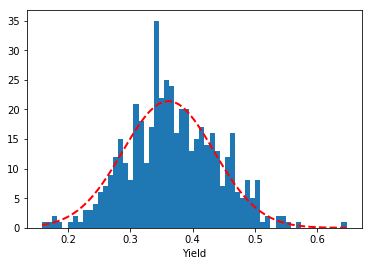

[[ 1.00059624e+00  3.12566987e-06 -2.27662656e-03]
 [ 3.12566987e-06  1.54439758e-05 -2.40930197e-08]
 [-2.27662656e-03 -2.40930197e-08  1.55046174e-05]] [21.42648688  0.36104111  0.07291904]


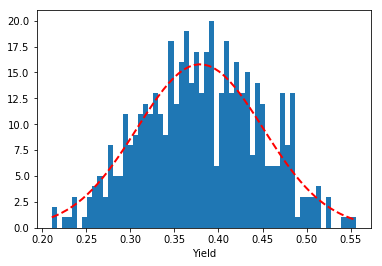

[[5.25627940e-01 2.60889554e-06 1.64578971e-03]
 [2.60889554e-06 1.44154559e-05 2.91699002e-08]
 [1.64578971e-03 2.91699002e-08 1.50846465e-05]] [15.79173125  0.37913574 -0.07176722]


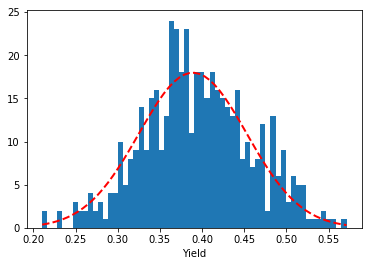

[[ 6.50589646e-01 -4.24094901e-07 -1.55505711e-03]
 [-4.24094901e-07  1.10035091e-05  3.49089028e-09]
 [-1.55505711e-03  3.49089028e-09  1.10966969e-05]] [17.97155577  0.38900794  0.0640477 ]


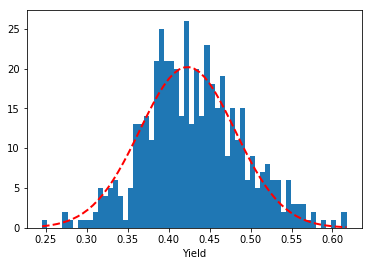

[[ 8.16372956e-01  3.45956485e-07 -1.56967200e-03]
 [ 3.45956485e-07  9.03369835e-06 -2.22361938e-09]
 [-1.56967200e-03 -2.22361938e-09  9.04654306e-06]] [20.18260447  0.42279749  0.05814785]
[0.41002512274598013, 0.2118429970627652, 0.20206009637420733, 0.16230262139071364, 0.11980539334845412, 0.12731588512360645, 0.10961474093782718, 0.11727128131093013, 0.10913739211505179, 0.09614287099081886, 0.08849578626207391, -0.08829757607924381, -0.08167686152809443, 0.08160215756897642, 0.0725376180084559, 0.0767304734522426, 0.0729190360096066, -0.07176722486569358, 0.0640477013590929, 0.058147848839552825]


In [19]:

sig = []
for this_data in data:
    x,y = find_sigma(this_data)
    print(x,y)
    sig.append(y[2])
    
print(sig)

In [16]:
#Fano = (b[:,4]**2*b[:,2] +b[:,5]**2*b[:,3] -sigma)**2/(b[:,6]*(b[:,4]**2*eps + V/1000*b[:,5]**2))

def calc_fano(data,sig):
    mean = []
    error = []
    for x, sigy in zip(data, sig):
        #x = data[i]
        U1 = x[:,4]
        U2 = x[:,5]
        sigQ = x[:,2]
        sigP = x[:,3]
        #sigy =sig[i]
        N = x[:,6]
        
        Fano = (-U1**2*sigQ**2-U2**2*sigP**2 + sigy**2)/(U1**2*eps**2 +U2**2*(V/1000)**2)
        Fano = Fano/N
        print(min(x[:,0]),max(x[:,0]))
        
        x,y,z = find_fano(Fano)
        
        mean.append(x[1])
        error.append(y[1,1])
        
        print("mean :",x[1],",","uncertainty in mean : ",y[1,1])
        print(y)

       
    return mean, error
        
        



0.014219569263712803 3.241507724325044


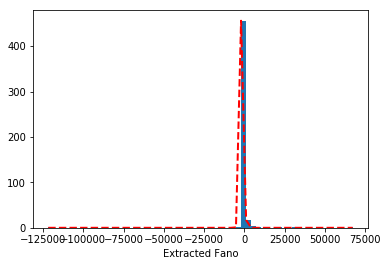

mean : -1640.8123184359033 , uncertainty in mean :  3391.952778295263
[[  260.16221166   938.39725729  -431.88299467]
 [  938.39725729  3391.9527783  -1552.96752125]
 [ -431.88299467 -1552.96752125   731.44798204]]
3.248323196963648 5.649542575869663


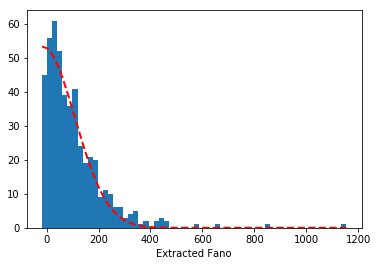

mean : -15.488393674031064 , uncertainty in mean :  230.9940637986488
[[   4.13285904  -23.54704233   11.26306235]
 [ -23.54704233  230.9940638  -137.01592146]
 [  11.26306235 -137.01592146   95.26292579]]
5.663623494008181 7.817589284705631


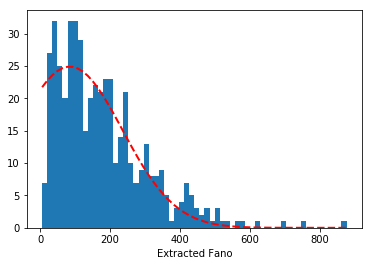

mean : 84.72858606483346 , uncertainty in mean :  320.542622855773
[[   1.29181543   -0.533203     -5.35679248]
 [  -0.533203    320.54262286 -225.35901962]
 [  -5.35679248 -225.35901962  256.91993918]]
7.81811762272608 10.093807845604154


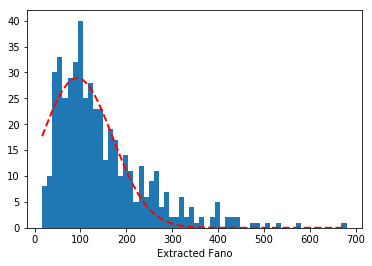

mean : 93.02177021665418 , uncertainty in mean :  31.49117907595869
[[  2.02615837   1.33248184  -5.06188787]
 [  1.33248184  31.49117908 -16.68600622]
 [ -5.06188787 -16.68600622  38.0930562 ]]
10.097221902595564 12.352813915349255


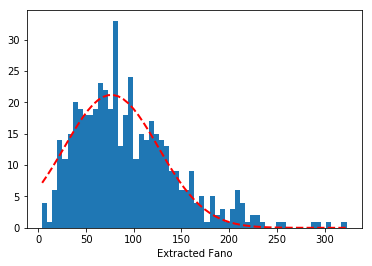

mean : 76.50340201417885 , uncertainty in mean :  7.186446621201722
[[ 0.91572421  0.21385087 -1.69252371]
 [ 0.21385087  7.18644662 -1.52284857]
 [-1.69252371 -1.52284857  8.69042959]]
12.352932159122261 14.913347777128347


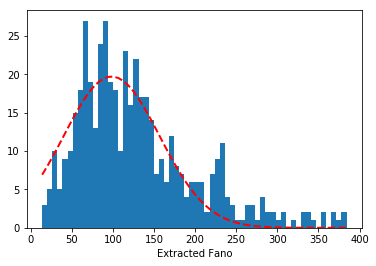

mean : 98.47559480862179 , uncertainty in mean :  16.477788469340318
[[ 1.28127259  0.40528603 -3.04147202]
 [ 0.40528603 16.47778847 -3.72894823]
 [-3.04147202 -3.72894823 20.03950889]]
14.941292901619649 17.98601805953817


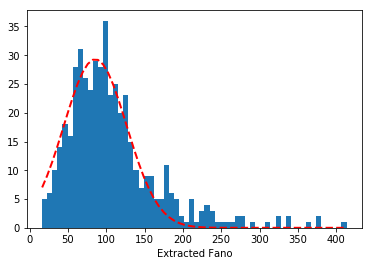

mean : 85.70650116763346 , uncertainty in mean :  2.9054747278296125
[[ 1.09023479  0.08081339 -1.12892048]
 [ 0.08081339  2.90547473 -0.30999098]
 [-1.12892048 -0.30999098  3.30563015]]
17.986485013356322 20.959581048828404


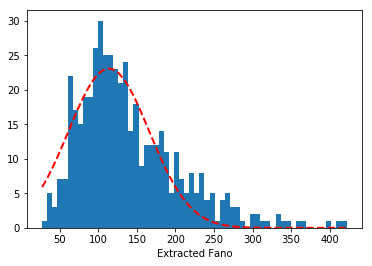

mean : 113.55525782272044 , uncertainty in mean :  8.517960861442537
[[ 1.20320867  0.16900817 -2.05019393]
 [ 0.16900817  8.51796086 -1.0748616 ]
 [-2.05019393 -1.0748616   9.82989372]]
20.972293404216668 24.36865696360892


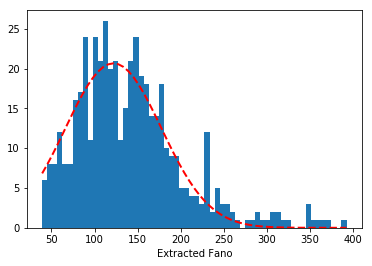

mean : 121.83606218336993 , uncertainty in mean :  9.162308191024021
[[ 0.87533584  0.22891425 -1.86495313]
 [ 0.22891425  9.16230819 -1.87360801]
 [-1.86495313 -1.87360801 11.04479979]]
24.375842656514987 27.99409585027029


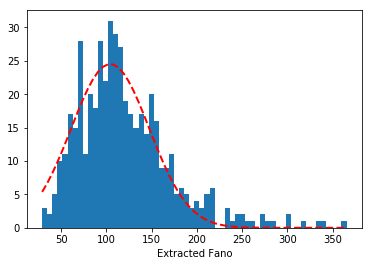

mean : 104.11315884326535 , uncertainty in mean :  4.699703698311935
[[ 1.11351695  0.09421882 -1.44215912]
 [ 0.09421882  4.6997037  -0.45068279]
 [-1.44215912 -0.45068279  5.29966835]]
28.000276654632597 32.25837544169714


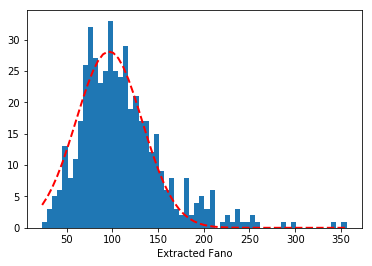

mean : 96.3474459261814 , uncertainty in mean :  2.2399285223565903
[[ 1.01395826  0.02510218 -0.90963238]
 [ 0.02510218  2.23992852 -0.08098894]
 [-0.90963238 -0.08098894  2.37588534]]
32.25887612036837 36.69472572607662


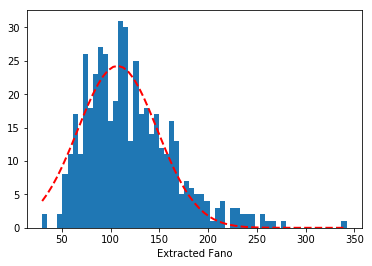

mean : 107.06848565397846 , uncertainty in mean :  5.193599709969351
[[ 1.37120222  0.06960269 -1.64104864]
 [ 0.06960269  5.19359971 -0.30322272]
 [-1.64104864 -0.30322272  5.65299805]]
36.70784506293706 41.6457743979615


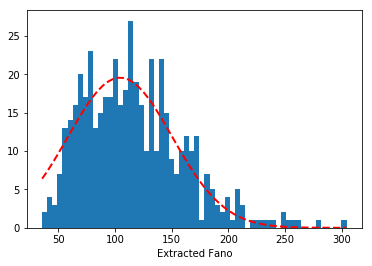

mean : 104.47863906318125 , uncertainty in mean :  7.161365093140219
[[ 0.90190684  0.2037293  -1.67269674]
 [ 0.2037293   7.16136509 -1.45072125]
 [-1.67269674 -1.45072125  8.62505715]]
41.65340474508058 47.66316040722924


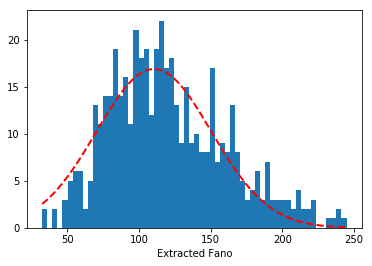

mean : 110.39147241202394 , uncertainty in mean :  5.206908463031804
[[ 0.69222643  0.04492911 -1.16261343]
 [ 0.04492911  5.20690846 -0.27412057]
 [-1.16261343 -0.27412057  5.63438263]]
47.686794527702176 54.52572075931794


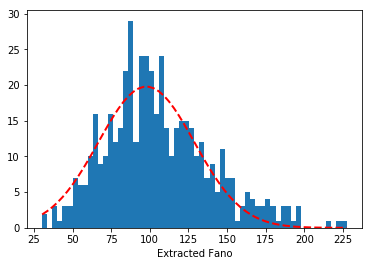

mean : 97.78567029804334 , uncertainty in mean :  2.915888459789267
[[ 0.88777286  0.01729657 -0.95814924]
 [ 0.01729657  2.91588846 -0.06648281]
 [-0.95814924 -0.06648281  3.03693649]]
54.527757908027894 63.73473138522847


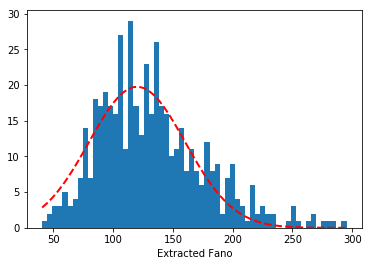

mean : 119.95037774356494 , uncertainty in mean :  6.340852457014252
[[ 1.13943184  0.05769801 -1.63842075]
 [ 0.05769801  6.34085246 -0.30050777]
 [-1.63842075 -0.30050777  6.8175476 ]]
63.735544770105776 75.49934892960232


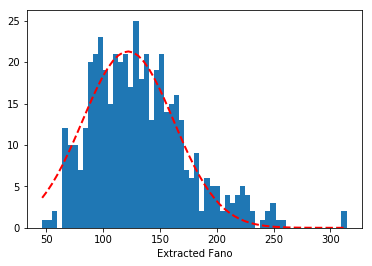

mean : 121.86576077591707 , uncertainty in mean :  3.5426946390874767
[[ 0.74169859  0.04540263 -1.00027295]
 [ 0.04540263  3.54269464 -0.22339964]
 [-1.00027295 -0.22339964  3.87486714]]
75.6102995133516 92.03106293462261


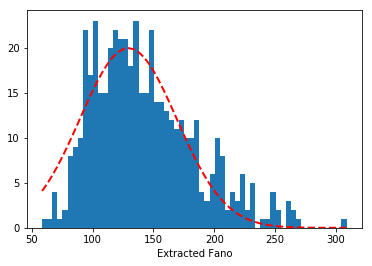

mean : 129.29936522758416 , uncertainty in mean :  4.679472779844383
[[ 0.86820916  0.07735947 -1.26527262]
 [ 0.07735947  4.67947278 -0.41550951]
 [-1.26527262 -0.41550951  5.2445166 ]]
92.06310840786178 120.99873997747866


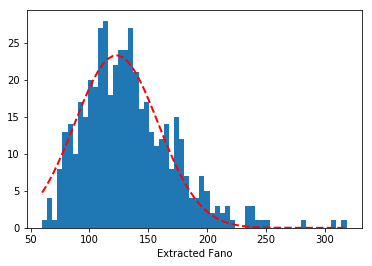

mean : 122.94709918934952 , uncertainty in mean :  2.2728600754868706
[[ 0.73074591  0.04780286 -0.8074117 ]
 [ 0.04780286  2.27286008 -0.19437811]
 [-0.8074117  -0.19437811  2.54012002]]
121.00748794367334 367.5252731578661


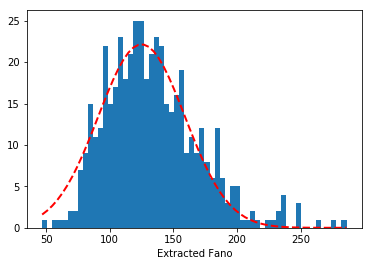

mean : 124.98337811502834 , uncertainty in mean :  2.0392092824757313
[[ 0.6463411   0.00767405 -0.6766951 ]
 [ 0.00767405  2.03920928 -0.02830827]
 [-0.6766951  -0.02830827  2.09486049]]


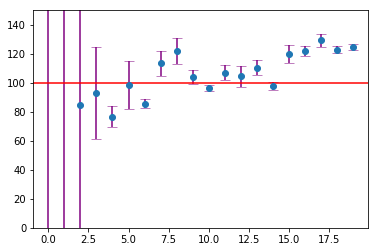

In [17]:
means,errors = calc_fano(data,sig)


x = np.arange(0,20)

plt.figure()
plt.errorbar(x,means,yerr=errors,fmt ='o',label = 'error', ecolor = 'purple', Linestyle = 'None', capsize=5, capthick=0.5)
plt.axhline(y=F, color='r', linestyle='-')
plt.ylim(0,150)
plt.show()